In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import MNIST
from torchvision import transforms

# Here's a simple MLP
class SimpleMLP(nn.Module):
    def __init__(self):
        super(SimpleMLP, self).__init__()
        self.fc1 = nn.Linear(784, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 10)

    def forward(self, x):
        x = x.flatten(1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Use a standard MNIST normalization
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

dataset = MNIST(root='./data', download=True, transform=transform)
BATCH_SIZE = int(len(dataset)/3) # we will use the whole dataset in production, but I want to test that batching works
dataloader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE) # num_workers = 2?

# criterion functional
criterion = F.cross_entropy

NUM_DIRS = 2 # number of random directions to sample, in addition to the gradient ascent + descent, and radially in + out.
MAX_OOM = 0 # maximum order of magnitude to sample
MIN_OOM = -1 # minimum order of magnitude to sample

In [2]:
# utils for model arithmetics
from copy import deepcopy

@torch.no_grad
def iadd(a:nn.Module, b:nn.Module):
    """add the parameters of b to a, inplace"""
    for a_param, b_param in zip(a.parameters(), b.parameters()):
        a_param.data.add_(b_param.data)
    return a

@torch.no_grad
def add(a_old:nn.Module, b:nn.Module):
    """add the parameters of b to a"""
    a = deepcopy(a_old)
    return iadd(a, b)

@torch.no_grad
def scale(a_old:nn.Module, b:float):
    """scale the parameters of a by b"""
    a = deepcopy(a_old)
    for a_param in a.parameters():
        a_param.data.mul_(b)
    return a

@torch.no_grad
def sub(a:nn.Module, b:nn.Module):
    """subtract the parameters of b from a"""
    neg_b = scale(b, -1)
    return iadd(neg_b, a)

@torch.no_grad
def abs(a:nn.Module):
    """return the norm of the parameters of a"""
    return torch.norm(torch.cat([param.data.flatten() for param in a.parameters()]))

@torch.no_grad
def norm(a:nn.Module):
    """normalize the parameters of a"""
    return scale(a, 1/abs(a))

@torch.no_grad
def rand_like(a:nn.Module):
    """random, normalised direction in the parameter space of a"""
    new = deepcopy(a)
    for param in new.parameters():
        param.data = torch.randn_like(param.data)
    
    return norm(new)

In [3]:
from copy import deepcopy
center_model = SimpleMLP()

# create a model to find the gradient
grad_model = deepcopy(center_model)
grad_model.to(device)
optimizer = torch.optim.SGD(grad_model.parameters(), lr=1)
optimizer.zero_grad()
torch.set_grad_enabled(True)

# take a single step of gradient descent
# gradient accumulate over the whole dataset
for data, target in dataloader:
    data, target = data.to(device), target.to(device)
    output = grad_model(data)
    loss = criterion(output, target)
    loss.backward()

optimizer.step()
# from this point on we wont need any gradients
torch.set_grad_enabled(False)


# calculate the direction of gradient decent from the center model
dir_ascent = sub(center_model, grad_model)
dir_ascent = norm(dir_ascent)
dir_descent = scale(dir_ascent, -1)

del grad_model


In [12]:
radial = norm(center_model)

dirs = {
    'Ascent': dir_ascent,
    'Descent': dir_descent,
    'Radially Out': radial,
    'Radially In': scale(radial,-1),
    }

# add random directions
dirs.update({f'Random {i}': rand_like(center_model) for i in range(NUM_DIRS)})

# check that they are all normalised
assert all(torch.isclose(abs(d), torch.tensor(1.0)) for d in dirs.values())

In [13]:
import pandas as pd
import numpy as np

# convert to base 2
POW_MIN_DIST = int(np.floor(MIN_OOM*np.log2(10)))
POW_MAX_DIST = int(np.ceil(MAX_OOM*np.log2(10)))

# will sample these distances
scales = 2. ** np.arange(POW_MIN_DIST, POW_MAX_DIST + 1)

# offset each direction by a different amount, so that we get a nice spread of distances, to avoid artefacts/robustness
offset_per_direction = 2. ** np.linspace(0, 1, len(dirs), endpoint=False)

# Initialize an empty list to hold tuples for MultiIndex
index_list = []

# Calculate distances using broadcasting
distances = np.outer(scales, offset_per_direction).T.flatten()

# Repeat directions accordingly
directions = np.repeat(list(dirs.keys()), len(scales))

# Create DataFrame directly from numpy arrays
df = pd.DataFrame(index=pd.MultiIndex.from_arrays([directions, distances], names=['Direction', 'Distance']))

df


Empty DataFrame
Columns: []
Index: [(Ascent, 0.0625), (Ascent, 0.125), (Ascent, 0.25), (Ascent, 0.5), (Ascent, 1.0), (Descent, 0.07015387801933581), (Descent, 0.14030775603867163), (Descent, 0.28061551207734325), (Descent, 0.5612310241546865), (Descent, 1.122462048309373), (Radially Out, 0.07874506561842957), (Radially Out, 0.15749013123685915), (Radially Out, 0.3149802624737183), (Radially Out, 0.6299605249474366), (Radially Out, 1.2599210498948732), (Radially In, 0.08838834764831845), (Radially In, 0.1767766952966369), (Radially In, 0.3535533905932738), (Radially In, 0.7071067811865476), (Radially In, 1.4142135623730951), (Random 0, 0.09921256574801246), (Random 0, 0.19842513149602492), (Random 0, 0.39685026299204984), (Random 0, 0.7937005259840997), (Random 0, 1.5874010519681994), (Random 1, 0.11136233976754241), (Random 1, 0.22272467953508482), (Random 1, 0.44544935907016964), (Random 1, 0.8908987181403393), (Random 1, 1.7817974362806785)]

In [15]:
# fill the dataframe with the models
for dir_name, dist in df.index:
    shift = scale(dirs[dir_name], dist)     # shift = direction * distance
    location = iadd(shift, center_model)    # location = center + shift
    df.loc[(dir_name, dist), 'Model'] = location

df

Model
Direction    Distance                                                   
Ascent       0.062500  SimpleMLP(\n  (fc1): Linear(in_features=784, o...
             0.125000  SimpleMLP(\n  (fc1): Linear(in_features=784, o...
             0.250000  SimpleMLP(\n  (fc1): Linear(in_features=784, o...
             0.500000  SimpleMLP(\n  (fc1): Linear(in_features=784, o...
             1.000000  SimpleMLP(\n  (fc1): Linear(in_features=784, o...
Descent      0.070154  SimpleMLP(\n  (fc1): Linear(in_features=784, o...
             0.140308  SimpleMLP(\n  (fc1): Linear(in_features=784, o...
             0.280616  SimpleMLP(\n  (fc1): Linear(in_features=784, o...
             0.561231  SimpleMLP(\n  (fc1): Linear(in_features=784, o...
             1.122462  SimpleMLP(\n  (fc1): Linear(in_features=784, o...
Radially Out 0.078745  SimpleMLP(\n  (fc1): Linear(in_features=784, o...
             0.157490  SimpleMLP(\n  (fc1): Linear(in_features=784, o...
             0.314980  SimpleMLP(\n  (fc1): Linear(in_features=784, o...
             0.629961  SimpleMLP(\n  (fc1): Linear(in_features=784, o...
             1.259921  SimpleMLP(\n  (fc1): Linear(in_features=784, o...
Radially In  0.088388  SimpleMLP(\n  (fc1): Linear(in_features=784, o...
             0.176777  SimpleMLP(\n  (fc1): Linear(in_features=784, o...
             0.353553  SimpleMLP(\n  (fc1): Linear(in_features=784, o...
             0.707107  SimpleMLP(\n  (fc1): Linear(in_features=784, o...
             1.414214  SimpleMLP(\n  (fc1): Linear(in_features=784, o...
Random 0     0.099213  SimpleMLP(\n  (fc1): Linear(in_features=784, o...
             0.198425  SimpleMLP(\n  (fc1): Linear(in_features=784, o...
             0.396850  SimpleMLP(\n  (fc1): Linear(in_features=784, o...
             0.793701  SimpleMLP(\n  (fc1): Linear(in_features=784, o...
             1.587401  SimpleMLP(\n  (fc1): Linear(in_features=784, o...
Random 1     0.111362  SimpleMLP(\n  (fc1): Linear(in_features=784, o...
             0.222725  SimpleMLP(\n  (fc1): Linear(in_features=784, o...
             0.445449  SimpleMLP(\n  (fc1): Linear(in_features=784, o...
             0.890899  SimpleMLP(\n  (fc1): Linear(in_features=784, o...
             1.781797  SimpleMLP(\n  (fc1): Linear(in_features=784, o...

Parallel evaluation with vmap()


In [37]:
from torch.func import stack_module_state
from torch.func import functional_call
from torch.nn.functional import cross_entropy
from torch import vmap
from time import perf_counter
from contextlib import contextmanager

@contextmanager
def timer(description):
    print(description, end='')
    start = perf_counter()
    yield
    print(f' in {perf_counter()-start:.2}s')

# add the center model
ensemble = [center_model] + list(df['Model'])

# stack to prepare for vmap
params, buffers = stack_module_state(ensemble)

with timer(f'Moving stacked ensemble to {device}'):
    # Move parameters to the specified device
    params = {name: tensor.to(device) for name, tensor in params.items()}
    # Move buffers to the specified device
    buffers = {name: tensor.to(device) for name, tensor in buffers.items()}


stacked_ensemble = (params, buffers)

# Construct a "stateless" version of one of the models. It is "stateless" in
# the sense that the parameters are meta Tensors and do not have storage.
meta_model = deepcopy(df['Model'][0])
meta_model = meta_model.to('meta')

def meta_model_loss(params_and_buffers, data, target):
    predictions = functional_call(meta_model, params_and_buffers, (data,))
    predictions = predictions.double()
    loss = criterion(predictions, target)  # Compute loss per sample
    return loss

ensembled_loss = vmap(meta_model_loss, in_dims=(0, None, None)) # adds an ensemble dimension to the first two arguments (params, buffers)
# data and target are not ensembled over, so we don't add an ensemble dimension for them
batch_losses = []

with timer('Evaluating stacked ensemble'):
    for data, target in dataloader:
        data, target = data.to(device), target.to(device)
        batch_loss = ensembled_loss(stacked_ensemble, data, target)
        batch_losses.append(batch_loss)

loss_tensor = torch.mean(torch.stack(batch_losses), dim=0)


AttributeError: 'float' object has no attribute 'training'

In [32]:
# Convert the loss tensor to a list and unpack
center_loss, *dir_losses = loss_tensor.tolist()

# Ensure the length of dir_losses matches the DataFrame length
assert len(dir_losses) == len(df)

# Add the directional losses to the DataFrame
df['Loss'] = dir_losses

# Add the center_loss to each Direction, for Distance=0
for direction in df.index.get_level_values('Direction').unique():
    df.loc[(direction, 0.0), 'Loss'] = center_loss

df.sort_index(inplace=True)

df

AssertionError: Length of directional losses does not match the DataFrame.

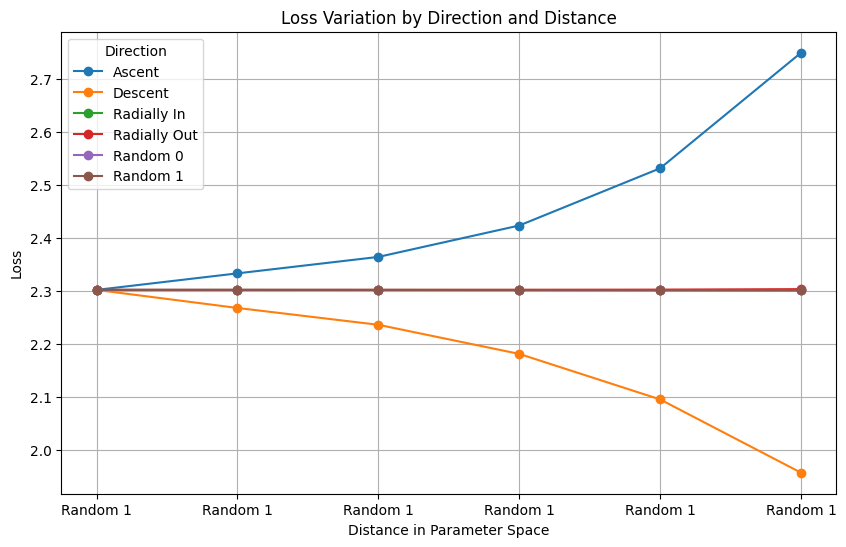

In [35]:
import matplotlib.pyplot as plt

# Ensure your DataFrame df is indexed by ('Direction', 'Distance')
# Plotting directly from MultiIndexed DataFrame
fig, ax = plt.subplots(figsize=(10, 6))

# Group by the 'Direction' level of the index
for direction, data in df.groupby(level='Direction'):
    # Plot each group
    data['Loss'].plot(ax=ax, label=direction, marker='o', linestyle='-')

ax.set_xlabel('Distance in Parameter Space')
ax.set_ylabel('Loss')
ax.set_title('Loss Variation by Direction and Distance')
ax.grid(True)
ax.legend(title='Direction')
plt.show()


In [34]:
df

,Distance,Model,Loss
Direction,,,
Ascent,0.000000,NaN,2.302217
Ascent,0.062500,"SimpleMLP(\n (fc1): Linear(in_features=784, o...",2.333452
Ascent,0.125000,"SimpleMLP(\n (fc1): Linear(in_features=784, o...",2.364491
Ascent,0.250000,"SimpleMLP(\n (fc1): Linear(in_features=784, o...",2.423778
Ascent,0.500000,"SimpleMLP(\n (fc1): Linear(in_features=784, o...",2.531808
Ascent,1.000000,"SimpleMLP(\n (fc1): Linear(in_features=784, o...",2.749978
Descent,0.000000,NaN,2.302217
Descent,0.070154,"SimpleMLP(\n (fc1): Linear(in_features=784, o...",2.268144
Descent,0.140308,"SimpleMLP(\n (fc1): Linear(in_features=784, o...",2.236372
